In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import shutil
from IPython.display import FileLink

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification
from transformers import AdamWeightDecay
from datasets import Dataset, DatasetDict

import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PolynomialDecay
print(tf.__version__)
print(tf.config.list_physical_devices())

# startegy for training on multiple gpus
mirrored_strategy = tf.distribute.MirroredStrategy()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.11.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
dataset = pd.read_csv('../input/edos-1m/EDOS 1M.csv')

dataset_percentage = 0.5
if dataset_percentage < 1:
    dataset = dataset.sample(n=int(len(dataset)*dataset_percentage))

X,y = dataset["uttr"], dataset["eb+_emot"]

print(X.head(5))
print(type(X), end="\n\n")
print(y.head(5))
print(type(y), end="\n\n")

classes = np.sort(y.unique())
classes

2180690                                        Bye , Polly .
1263643      So , you are slumming at our end of the table ?
138503     I 've been stretching muscles that haven 't be...
127089                                               Never .
2801283     Mommy , it 's cold in here . Just for a minute .
Name: uttr, dtype: object
<class 'pandas.core.series.Series'>

2180690        wishing
1263643    questioning
138503         annoyed
127089         neutral
2801283         afraid
Name: eb+_emot, dtype: object
<class 'pandas.core.series.Series'>



array(['acknowledging', 'afraid', 'agreeing', 'angry', 'annoyed',
       'anticipating', 'anxious', 'apprehensive', 'ashamed', 'caring',
       'confident', 'consoling', 'content', 'devastated', 'disappointed',
       'disgusted', 'embarrassed', 'encouraging', 'excited', 'faithful',
       'furious', 'grateful', 'guilty', 'hopeful', 'impressed', 'jealous',
       'joyful', 'lonely', 'neutral', 'nostalgic', 'prepared', 'proud',
       'questioning', 'sad', 'sentimental', 'suggesting', 'surprised',
       'sympathizing', 'terrified', 'trusting', 'wishing'], dtype=object)

# Preparation

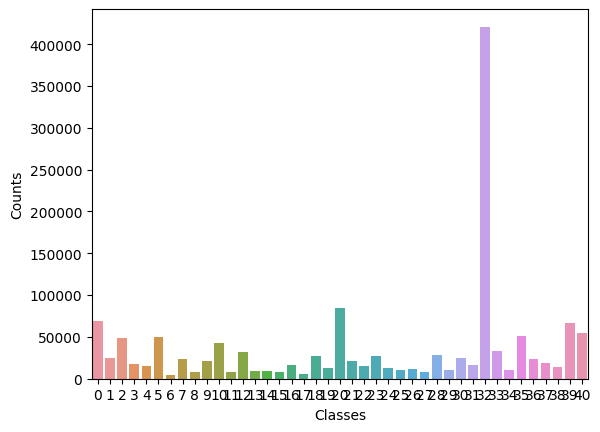

In [3]:
# plot classes distribution
counts = pd.get_dummies(y).sum()

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = [i for i in range(len(classes))], y = counts)
plt.show()

In [4]:
# train, validation and test split
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, stratify=y)

print("train size: ", len(train_X))
print("validation size: ", len(valid_X))

train size:  990299
validation size:  424414


In [5]:
# support function to compute top-k accuracy
def top_k_accuracy(true_y, pred_y, k):
    # Get the top k predictions for each sample in the validation dataset
    pred_y_top_k = np.argsort(pred_y, axis=1)[:, -k:]

    # Get the ground truth labels for the validation dataset
    true_labels = np.asarray(true_y)

    # Compute top k accuracy
    top_k_accuracy = np.mean(np.any(pred_y_top_k == true_labels.reshape(true_labels.shape[0], 1), axis=1))
    return f"Top-{k} accuracy: " + str(top_k_accuracy)

# Single utterance classification - Transformer-based model

In [6]:
# model metadata
model_name = "distilbert-base-uncased"

# map expected ids to their labels and viceversa
id2label = dict(zip(range(len(classes)), classes))
label2id = dict(zip(classes, range(len(classes))))
id2label

{0: 'acknowledging',
 1: 'afraid',
 2: 'agreeing',
 3: 'angry',
 4: 'annoyed',
 5: 'anticipating',
 6: 'anxious',
 7: 'apprehensive',
 8: 'ashamed',
 9: 'caring',
 10: 'confident',
 11: 'consoling',
 12: 'content',
 13: 'devastated',
 14: 'disappointed',
 15: 'disgusted',
 16: 'embarrassed',
 17: 'encouraging',
 18: 'excited',
 19: 'faithful',
 20: 'furious',
 21: 'grateful',
 22: 'guilty',
 23: 'hopeful',
 24: 'impressed',
 25: 'jealous',
 26: 'joyful',
 27: 'lonely',
 28: 'neutral',
 29: 'nostalgic',
 30: 'prepared',
 31: 'proud',
 32: 'questioning',
 33: 'sad',
 34: 'sentimental',
 35: 'suggesting',
 36: 'surprised',
 37: 'sympathizing',
 38: 'terrified',
 39: 'trusting',
 40: 'wishing'}

In [7]:
# building the datasets
train_data = Dataset.from_pandas(pd.DataFrame({"text": train_X, "label": np.argmax(pd.get_dummies(train_y).to_numpy(), axis=1)}), preserve_index=False)
valid_data = Dataset.from_pandas(pd.DataFrame({"text": valid_X, "label": np.argmax(pd.get_dummies(valid_y).to_numpy(), axis=1)}), preserve_index=False)

# shuffling is performed at the previous operation -> we need to redefine valid_y
valid_y = valid_data['label']

data = DatasetDict()
data['train'] = train_data
data['validation'] = valid_data

print(data['train'][0])
data

{'text': "Hey . Hey . How 'd it go at the label ? Uh ... I think I fixed it temporarily . Now I gotta fix my sister .", 'label': 11}


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 990299
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 424414
    })
})

In [8]:
# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# tokenize the data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_data = data.map(preprocess_function, batched=True)

print(tokenized_data["train"][0])
tokenized_data

  0%|          | 0/991 [00:00<?, ?ba/s]

  0%|          | 0/425 [00:00<?, ?ba/s]

{'text': "Hey . Hey . How 'd it go at the label ? Uh ... I think I fixed it temporarily . Now I gotta fix my sister .", 'label': 11, 'input_ids': [101, 4931, 1012, 4931, 1012, 2129, 1005, 1040, 2009, 2175, 2012, 1996, 3830, 1029, 7910, 1012, 1012, 1012, 1045, 2228, 1045, 4964, 2009, 8184, 1012, 2085, 1045, 10657, 8081, 2026, 2905, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 990299
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 424414
    })
})

In [9]:
# metadata
batch_size = 16
num_epochs = 3
patience = 3
only_fine_tune = False

# convert datasets to a suitable format for tensorflow
data_collator = DataCollatorWithPadding(tokenizer, return_tensors="tf")

tf_train_dataset = tokenized_data["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_dataset = tokenized_data["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

# create optimizer and learning rate scheduler
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=2e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
opt = AdamWeightDecay(learning_rate=lr_scheduler,
                      weight_decay_rate=0.01)

# from within the selected parallelization strategy...
with mirrored_strategy.scope():
    
    # ...load the model...
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(classes), id2label=id2label, label2id=label2id)
    if only_fine_tune:
        for i in range(1):
            model.layers[i].trainable = False
    
    # ...and compile it
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])

model.summary()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  31529     
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,985,001
Trainable params: 66,985,001
Non-trainable params: 0
_________________________________________________________________


In [10]:
# training
history = model.fit(
          tf_train_dataset,
          validation_data=tf_validation_dataset,
          epochs=num_epochs,                                  
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)]
)

Epoch 1/3
61893/61893 [==============================] - 5630s 91ms/step - loss: 0.7172 - accuracy: 0.7734 - val_loss: 0.5501 - val_accuracy: 0.8169
Epoch 2/3
61893/61893 [==============================] - 5630s 91ms/step - loss: 0.4444 - accuracy: 0.8505 - val_loss: 0.4936 - val_accuracy: 0.8365
Epoch 3/3
61893/61893 [==============================] - 5609s 91ms/step - loss: 0.3042 - accuracy: 0.8968 - val_loss: 0.4932 - val_accuracy: 0.8428


In [11]:
reload = False

if reload:
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(classes), id2label=id2label, label2id=label2id)
    model.load_weights('bert_model')
    bert_y = model.predict(tf_validation_dataset)["logits"]

In [12]:
# validate the model -> accuracy should correspond to final val_accuracy
bert_y = model.predict(tf_validation_dataset)["logits"]

print('Results for BERT-based classifier:')
print(classification_report(valid_y, np.argmax(bert_y, axis=1), target_names=classes))
print(top_k_accuracy(valid_y, bert_y, 3))

26526/26526 [==============================] - 809s 30ms/step
Results for BERT-based classifier:
               precision    recall  f1-score   support

acknowledging       0.78      0.79      0.78     20705
       afraid       0.80      0.82      0.81      7405
     agreeing       0.79      0.76      0.78     14512
        angry       0.71      0.67      0.69      5306
      annoyed       0.68      0.67      0.68      4537
 anticipating       0.82      0.83      0.82     15120
      anxious       0.72      0.69      0.70      1306
 apprehensive       0.79      0.77      0.78      6976
      ashamed       0.70      0.62      0.66      2246
       caring       0.76      0.77      0.77      6412
    confident       0.78      0.77      0.77     12818
    consoling       0.77      0.73      0.75      2579
      content       0.84      0.85      0.84      9702
   devastated       0.70      0.66      0.68      2616
 disappointed       0.75      0.72      0.74      2729
    disgusted       0.

In [13]:
model.save('bert_model')
shutil.make_archive('bert_model', 'zip', 'bert_model')
FileLink(r'bert_model.zip')

/kaggle/working/bert_model.zip